# Notebook 1: Quantum States, Quantum Gates, and Quantum Circuits

**Date:** 08 March 2021<br>
**Author:** Ameya Thete

This notebook provides an introduction to the `Qiskit` environment and framework, which allows you to create quantum circuits and run them on a simulator and even on an actual quantum computer! (More on that later). 

`Qiskit` is an open-source framework which primarily uses the Python programming language, and hence it is assumed that you have some working knowledge of the python. It is also assumed that you know how Jupyter notebooks work. In case you are not familiar with Python or Jupyter, here are a few resources to get you started: 

- Python: https://youtu.be/H1elmMBnykA
- Jupyter: https://youtu.be/jZ952vChhuI

In case you do not wish to run these notebooks locally, [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb) provides a way for you to run notebooks on the cloud. Check out their tutorial linked above.

A great resource to explore quantum computing is the [IBM Quantum textbook](https://qiskit.org/textbook/preface.html). It provides a really good coverage of the topic at hand along with a Qiskit demo. Furthermore, if you have any queries about the functions and classes in Qiskit, your first reference should be the [Qiskit documentation](https://www.qiskit.org/documentation/). 

#### Installing some packages

In order to run `Qiskit`, we would have to install the package, in case you do not have it already. To do so, uncomment the line and run the cell below.

**Note:** If you're running Jupyter locally, I would advise creating a virtual environment to install the package into and then running Jupyter in that environment to mitigate any issues with your existing packages or preventing them from breaking. On Colab however, feel free to run the cell below to install `Qiskit`.

In [1]:
# !pip install -U qiskit

## Single-Qubit States

$ \newcommand{\ket}[1]{\left|{#1}\right\rangle} $
$ \newcommand{\bra}[1]{\left\langle{#1}\right|} $

We know that the state of any two-level quantum system can be expressed as a linear combination of the basis vectors of a Hilbert space $\mathcal{H}$. By convention, we choose the basis vectors to be the eigenvectors of the $\hat{S}_z$ operator. Therefore, any state $\ket{\psi}$ can be expressed as $$ \ket{\psi} = \alpha\ket{0} + \beta\ket{1}$$
where $\alpha, \beta \in \mathbb{C}$

Let's start off by creating a single qubit quantum circuit in `Qiskit`

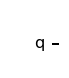

In [2]:
from qiskit import QuantumCircuit

singleQubitCirc = QuantumCircuit(1) # Creates a quantum circuit with 1 qubit.
singleQubitCirc.draw('mpl') # Draws the quantum circui

In quantum circuits, single qubits are represented by solid, horizontal lines. The circuit we created, `singleQubitCirc`, does not have any gates. Hence, if you apply this circuit onto any qubit, it remains in its original state forever. Let's see that in action. 

We'll start off by creating a quantum state, called a `Statevector` object in Qiskit parlance, and then apply the circuit we created above onto the state. We should see no change since, well, there's nothing in the circuit. 

In [3]:
from qiskit.quantum_info import Statevector as sv

qubitState = sv.from_label('0') # Creates the state |0>

In [4]:
print(qubitState)
print(qubitState.data)

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
[1.+0.j 0.+0.j]


We can see that that the state created is the state $$ \ket{0} = \begin{pmatrix} 1 \\ 0 \end{pmatrix} $$

If we now evolve this state using the circuit we create above (by means of the `evolve` method), we should find no change.

In [5]:
newState = qubitState.evolve(singleQubitCirc)
newState.data

array([1.+0.j, 0.+0.j])

## Quantum Gates and Circuits

Now that we've seen how a qubit is created, let's see how we can make a very basic quantum circuit and perform measurement operations on it. As an example, we shall take the state $\ket{0}$, apply a Hadamard gate, and them perform a measurement. 

Theroretically, what we see is that applying a Hadamard $H$ on $\ket{0}$ yields $$H\ket{0} = \frac{1}{\sqrt{2}}\left(\ket{0} + \ket{1}\right)$$

This says that if we perform a measurement operation (in the $z$-basis, assumed implicitly) _after_ the Hadamard as been applied, there is an equal probability of getting $0$ or $1$. To start, let's create a quantum circuit that does this and initialise it with $\ket{0}$.

In [6]:
qc = QuantumCircuit(1, 1) # Creates a quantum circuit with 1 qubit and 1 classical bit (to store the 
                                   # measurement result)

initialState = [1+0j, 0+0j] # The initial state |0>
qc.initialize(initialState, 0) # Initalise the 0th qubit with [1 0]

qc.h(0)                   # Applies a H gate onto the 0th qubit
qc.barrier()              # Allows you to separate components in the circuit for better readability
qc.measure(0, 0)          # Measures the 0th qubit and stores the result in the 0th classical bit

Here's what the simple circuit looks like:

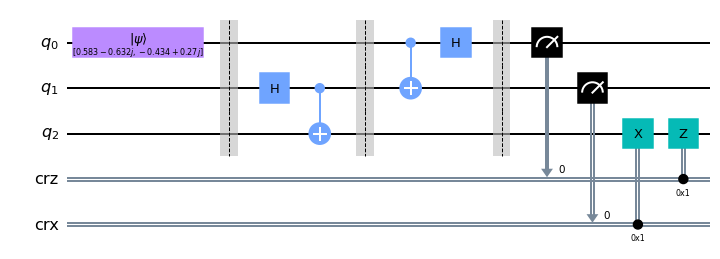

In [27]:
qc.draw("mpl")

We can now measure the qubit. To do this, we simulate this circuit on one of Qiskit's own simulator called the `statevector_simulator`. Other simulators also exist, but we need not be concerned with those right now; however feel free to explore them further and see if they make any difference.

In [8]:
from qiskit import Aer, execute

backend = Aer.get_backend('statevector_simulator') # The simulator we've chosen

shots = 100000 # The number of repetitions of each circuit, for sampling. Since the measurement is a 
            # statistical process, those many repetitions of the circuit are created and simulated to get the output.

In [9]:
result = execute(experiments=qc,backend=backend, shots=shots).result()
counts = result.get_counts(qc)

If we now plot a histogram of the counts with their probabilities, we should get a result that agrees with theory (although _sometimes_ you might get some absurd results, but generally you get agreeable values).

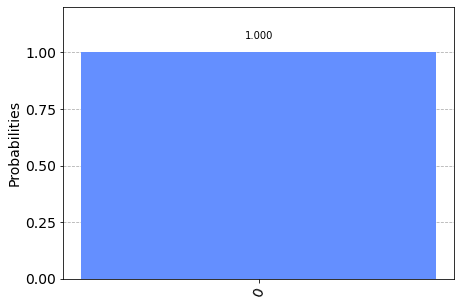

In [10]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

And we do! We get equal probabilites for getting 0 or 1. 

### A Slightly Advanced Circuit

Now that we've seen how you can implement a really basic quantum circuit and perform measurements on it, let's do something slightly more advanced. Let's look at the quantum teleportation circuit we've studied. 

In [11]:
from qiskit import QuantumRegister, ClassicalRegister, assemble
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector

In [12]:
# Setup the teleportation circuit
qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

In [13]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

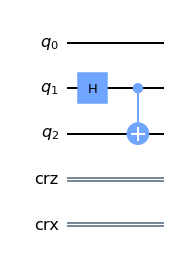

In [14]:
create_bell_pair(teleportation_circuit, 1, 2)

# And view the circuit so far:
teleportation_circuit.draw('mpl')

In [15]:
# Alice performs a Bell Measurement
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

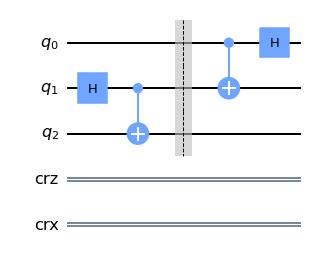

In [16]:
teleportation_circuit.barrier()
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw('mpl')

In [17]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

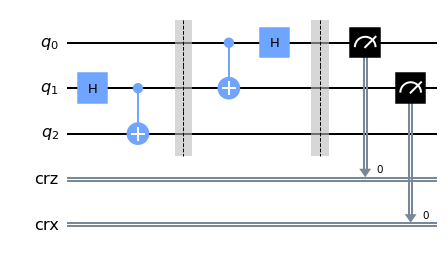

In [18]:
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw('mpl')

In [19]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

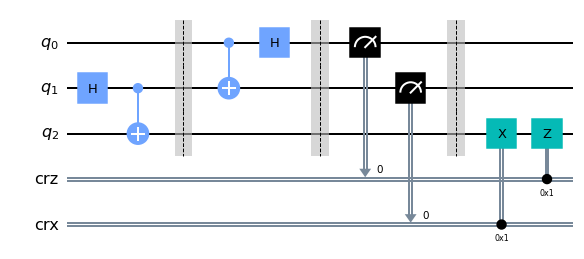

In [20]:
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw('mpl')

Let's see if the circuit actually teleports a state. We initialise Alice's qubit ($q_1$) to a random state $|\psi\rangle$. Then, we can use the statevector simulator to verify our qubit has been teleported.

In [21]:
psi = random_statevector(dims=2)
psi.data

array([ 0.58270235-0.6317503j , -0.43425438+0.26976411j])

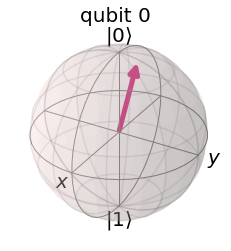

In [22]:
from qiskit.visualization import plot_bloch_multivector 

plot_bloch_multivector(psi.data)

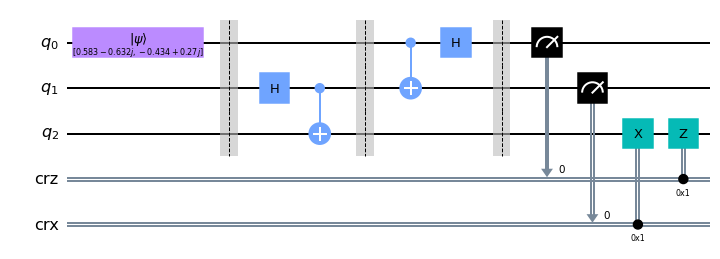

In [28]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.initialize(psi.data, 0)
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw("mpl")

In [24]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()

In [25]:
out_vector

array([-0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.58270235-0.6317503j ,
       -0.        +0.j        , -0.        +0.j        ,
        0.        -0.j        , -0.43425438+0.26976411j])

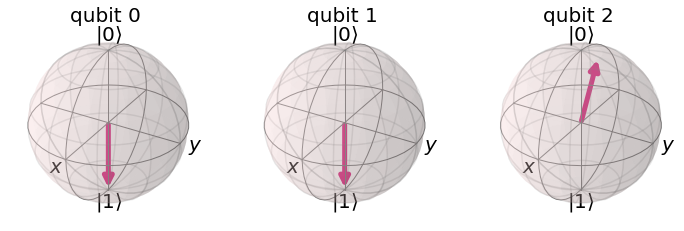

In [26]:
plot_bloch_multivector(out_vector)

We see that qubit2 now has the same state as the initial state we started out with.